In [1]:
#!unzip EmergencyVehicleSirens.zip
#!unzip RoadNoises.zip

In [2]:
import os
import random
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_model_optimization as tfmot
from time import time
from glob import glob
from preprocessingFinalProject import *
from functools import partial

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)


TEAM_FOLDER = os.path.join('.', 'FINALRESULTS')
PLOT_FOLDER = os.path.join(TEAM_FOLDER, 'PLOTS')

if not os.path.exists(TEAM_FOLDER):
    os.makedirs(TEAM_FOLDER)
if not os.path.exists(PLOT_FOLDER):
    os.makedirs(PLOT_FOLDER)

MODEL_NAME = "model"
MODEL_PATH = os.path.join(TEAM_FOLDER, 'MODEL', f'{MODEL_NAME}')
TFLITE_PATH = os.path.join(TEAM_FOLDER, 'TFLITE_MODEL')

roadnoises = tf.data.Dataset.list_files(['RoadNoises/*'])
ambulances = tf.data.Dataset.list_files(['EmergencyVehicleSirens/*'])

2023-04-19 10:59:05.736378: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-19 10:59:05.846978: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-19 10:59:05.847016: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-19 10:59:05.865367: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-19 10:59:06.902026: W tensorflow/stream_executor/platform/de

In [3]:
PREPROCESSING_ARGS = {
        'downsampling_rate': 48000,
        'frame_length_in_s': 0.016,
        'frame_step_in_s': 0.016,
        'num_mel_bins': 20,
        'num_coefficients': 20,
        'lower_frequency': 20,
        'upper_frequency': 24000}

TRAINING_ARGS = {
        'batch_size': 20,
        'initial_learning_rate': 0.01,
        'end_learning_rate': 1.e-5,
        'epochs': 20,
        'model_filter': 64,
        'alpha': 0.2,
        'initial_sparsity': 0.2,
        'final_sparsity': 0.6
    }

# VISUALIZATION

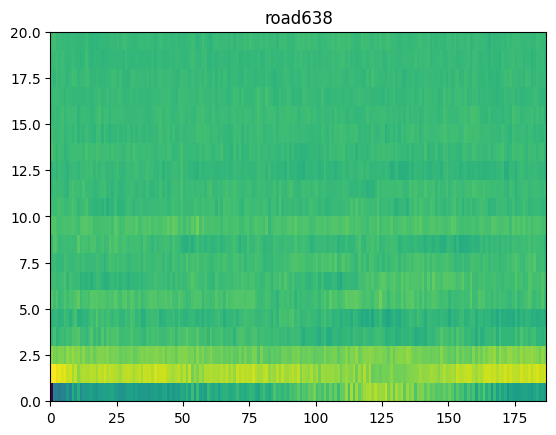

In [4]:
for ambulance, road in zip(ambulances.take(10), roadnoises.take(10)):
    #Get name for saving purposes
    ambulanceName = tf.strings.split(tf.strings.split(ambulance, "/")[1], ".")[0].numpy().decode()
    roadName = tf.strings.split(tf.strings.split(road, "/")[1], ".")[0].numpy().decode()
    #Convert audio to MFCC
    ambulanceMfcc, _ = get_mfccs_training(ambulance, **PREPROCESSING_ARGS)
    roadMfcc, _ = get_mfccs_training(road, **PREPROCESSING_ARGS)
    #Transpose for visualization
    ambulanceVis = tf.transpose(ambulanceMfcc)
    roadVis = tf.transpose(roadMfcc)
    #Plot and savre
    plt.pcolormesh(ambulanceVis.numpy())
    plt.title(f"{ambulanceName}")
    plt.savefig(os.path.join(PLOT_FOLDER, f"{ambulanceName}"))
    plt.pcolormesh(roadVis.numpy())
    plt.title(f"{roadName}")
    plt.savefig(os.path.join(PLOT_FOLDER, f"{roadName}"))

# TRAINING

In [5]:
train_ambulances, val_ambulances, test_ambulances = split_dataset(ambulances)
train_roadnoises, val_roadnoises, test_roadnoises = split_dataset(roadnoises)
print(f"Dataset lengths: Emergency Vehicles = {len(ambulances)}, Roadnoises = {len(roadnoises)}")
print(f"Length train/val/test Ambulances: {len(train_ambulances)}/{len(val_ambulances)}/{len(test_ambulances)}")
print(f"Length train/val/test Roadnoises: {len(train_roadnoises)}/{len(val_roadnoises)}/{len(test_roadnoises)}")

Dataset lengths: Emergency Vehicles = 932, Roadnoises = 902
Length train/val/test Ambulances: 605/93/234
Length train/val/test Roadnoises: 586/90/226


In [6]:
#merge datasets and create single train val test datasets
train_files = train_ambulances.concatenate(train_roadnoises)
test_files = test_ambulances.concatenate(test_roadnoises)
val_files = val_ambulances.concatenate(val_roadnoises)

#shuffling 
test_files = test_files.shuffle(len(test_files)+1, seed=42)
val_files = val_files.shuffle(len(val_files)+1, seed=42)
train_files = train_files.shuffle(len(train_files)+1, seed=42)

print(f"Length train/val/test: {len(train_files)}/{len(val_files)}/{len(test_files)}")

Length train/val/test: 1191/183/460


In [7]:
def preprocess(filename):
    signal, label = get_frozen_spectrogram(filename)
    signal.set_shape(SHAPE)
    signal = tf.expand_dims(signal, -1)
    signal = tf.image.resize(signal, [32,32])
    label_id = tf.argmax(label == LABELS)
    return signal, label_id

def get_model(alpha, model_filter, input_shape):
    '''Returns the model'''
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Conv2D(filters=int(model_filter * alpha), kernel_size=[3, 3], strides=[2, 2], use_bias=False, padding='valid'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2D(filters=int(model_filter * alpha), kernel_size=[3, 3], strides=[1, 1], use_bias=False, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2D(filters=int(model_filter * alpha), kernel_size=[3, 3], strides=[1, 1], use_bias=False, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(units=len(LABELS)),
        tf.keras.layers.Softmax()
    ])
    return 

def save_model(model, path):
    '''Saves the model'''
    if not os.path.exists(path):
        os.makedirs(path)
    model.save(path)

def convert_model(model, model_path, tflite_path, model_name):
    '''Converts the saved model into tflite model and saves it (also zip version)'''
    converter = tf.lite.TFLiteConverter.from_saved_model(model_path)
    tflite_model = converter.convert()

    if not os.path.exists(tflite_path):
        os.makedirs(tflite_path)
    tflite_model_path = os.path.join(tflite_path, f'{model_name}.tflite')

    with open(tflite_model_path, 'wb') as fp:
        fp.write(tflite_model)

    with zipfile.ZipFile(f'{tflite_model_path}.zip', 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(tflite_model_path, f'{model_name}.tflite')
    
    sizes = {
        'tflite_model_size' : os.path.getsize(f'{tflite_model_path}') / 1024.0,
        'tflite_zip_model_size' : os.path.getsize(f'{tflite_model_path}.zip') / 1024.0
    }

    return tflite_model_path, sizes

def print_results(model_name, preprocessing_args, training_args, model_accuracies, sizes):
    '''saves results in a csv'''
    output_dict = {
                    'model_name': model_name,
                    **preprocessing_args,
                    **training_args,
                    **model_accuracies,
                    **sizes
            }

    return pd.DataFrame([output_dict])


def training(model_name, preprocessing_args, batch_size, initial_learning_rate, end_learning_rate, epochs, model_filter, alpha, initial_sparsity,
 final_sparsity):

    # ******************* Preprocessing ***********************************************************
    global SHAPE, get_frozen_spectrogram

    get_frozen_spectrogram = partial(get_mfccs_training, **preprocessing_args)

    for mfcc, label in train_files.map(get_frozen_spectrogram).take(1):
        SHAPE = mfcc[:preprocessing_args['num_coefficients']].shape


    train_ds = train_files.map(preprocess).batch(batch_size).cache()
    val_ds = val_files.map(preprocess).batch(batch_size)

    #get shape for model input
    for example_batch, example_labels in train_ds.take(1):
        input_shape = example_batch.shape[1:]


    # ******************* Model And Training *******************************************************
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=False)
    metrics = [tf.metrics.SparseCategoricalAccuracy()]
    callbacks = [tfmot.sparsity.keras.UpdatePruningStep()]

    linear_decay = tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=initial_learning_rate,
        end_learning_rate=end_learning_rate,
        decay_steps=len(train_ds) * epochs,
    )

    optimizer = tf.optimizers.Adam(learning_rate=linear_decay)

    begin_step = int(len(train_ds) * epochs * 0.2)
    end_step = int(len(train_ds) * epochs)

    # Pruning
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
            initial_sparsity= initial_sparsity,
            final_sparsity= final_sparsity,
            begin_step=begin_step,
            end_step=end_step
        )
    }


    model = tfmot.sparsity.keras.prune_low_magnitude(get_model(alpha, model_filter, input_shape), **pruning_params)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)
    print(model.summary())

    # ******************* Results ***************************************************************
    _, training_accuracy = model.evaluate(train_ds)
    _, validation_accuracy = model.evaluate(val_ds)

    accuracies = {
        'training_accuracy_tf': training_accuracy*100,
        'validation_accuracy_tf': validation_accuracy*100
    }

    fig = plt.figure()
    plt.plot(history.history['loss'], c='b')
    plt.plot(history.history['sparse_categorical_accuracy'], c='c')
    plt.title(f"Training Loss and Accuracy")
    plt.legend(['train_loss', 'train_accuracy'])
    plt.xlabel('Epoch')
    plt.savefig(os.path.join(PLOT_FOLDER, f"{model_name}.png"))
    
    return model, accuracies

2023-04-19 10:59:14.867619: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at functional_ops.cc:373 : INTERNAL: No function library
2023-04-19 10:59:14.869327: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at functional_ops.cc:373 : INTERNAL: No function library
2023-04-19 10:59:14.869545: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at functional_ops.cc:373 : INTERNAL: No function library
2023-04-19 10:59:15.585633: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at functional_ops.cc:373 : INTERNAL: No function library
2023-04-19 10:59:15.587884: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at functional_ops.cc:373 : INTERNAL: No function library
2023-04-19 10:59:15.588134: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at functional_ops.cc:373 : INTERNAL: No function library
2023-04-19 10:59:15.897008: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed 

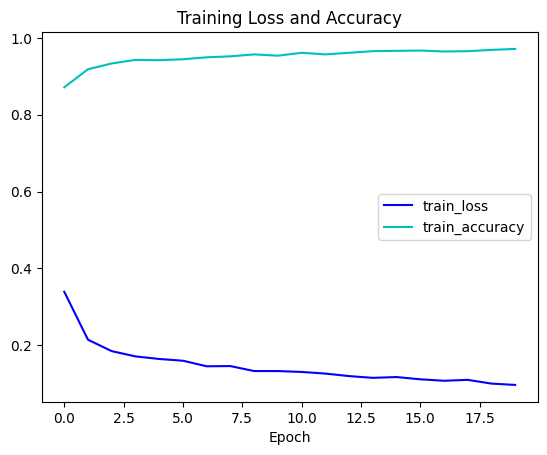

In [8]:
model, accuracies = training(MODEL_NAME, PREPROCESSING_ARGS, **TRAINING_ARGS)
save_model(model, MODEL_PATH)
TFLITE_NAME, sizes = convert_model(model, MODEL_PATH, TFLITE_PATH, MODEL_NAME) 

In [9]:
results = print_results(MODEL_NAME, PREPROCESSING_ARGS, TRAINING_ARGS, accuracies, sizes)
display(results)

,model_name,downsampling_rate,frame_length_in_s,frame_step_in_s,num_mel_bins,num_coefficients,lower_frequency,upper_frequency,batch_size,initial_learning_rate,end_learning_rate,epochs,model_filter,alpha,initial_sparsity,final_sparsity,training_accuracy_tf,validation_accuracy_tf,tflite_model_size,tflite_zip_model_size
0,model,48000,0.016,0.016,20,20,20,24000,20,0.01,0.00001,20,64,0.2,0.2,0.6,96.389586,96.174866,31.304688,9.355469


# TESTING

Model Evaluation (time and accuracy)

In [10]:
tflite_path = os.path.join(TFLITE_PATH, f'{MODEL_NAME}.tflite')
interpreter = tf.lite.Interpreter(model_path= tflite_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Number of inputs:", len(input_details))
print("Number of outputs:", len(output_details))
print("Input name:", input_details[0]['name'])
print("Input shape:", input_details[0]['shape'])
print("Output name:", output_details[0]['name'])
print("Output shape:", output_details[0]['shape'])

Number of inputs: 1
Number of outputs: 1
Input name: serving_default_input_1:0
Input shape: [ 1 32 32  1]
Output name: StatefulPartitionedCall:0
Output shape: [1 2]
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [11]:
avg_preprocessing_latency = 0
avg_model_latency = 0
latencies = []
accuracy = 0.0
predictions= []
labels = []
incorrect = []


sampling_rate_float32 = tf.cast(PREPROCESSING_ARGS['downsampling_rate'], tf.float32)
frame_length = int(sampling_rate_float32 * PREPROCESSING_ARGS['frame_length_in_s'])
frame_step = int(sampling_rate_float32 * PREPROCESSING_ARGS['frame_step_in_s'])

weigth_matrix = compute_linear_matrix(
    PREPROCESSING_ARGS['downsampling_rate'], 
    PREPROCESSING_ARGS['num_mel_bins'],
    PREPROCESSING_ARGS['lower_frequency'],
    PREPROCESSING_ARGS['upper_frequency'],
    frame_length
)


for filename in test_files:
    
    audio_binary = tf.io.read_file(filename)

    # NEED ONLY FOR TESTING
    true_label = get_label(filename)
    true_label = true_label.numpy().decode()
    labels.append(LABELS.index(true_label))

    # PRE-PROCESSING (AUDIO -> MFCCS)
    start_preprocess = time()

    mfccs = get_mfcc(audio_binary, 
                    PREPROCESSING_ARGS['downsampling_rate'],
                    frame_length,
                    frame_step,
                    weigth_matrix)
    
    mfccs = tf.expand_dims(mfccs, 0)  # batch axis
    mfccs = tf.expand_dims(mfccs, -1)  # channel axis   
    mfccs = tf.image.resize(mfccs, [32,32])

    end_preprocess = time()

    #INFERENCE WITH TFLITE MODEL 

    interpreter.set_tensor(input_details[0]['index'], mfccs)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])

    end_inference = time()

    top_index = np.argmax(output[0])
    predicted_label = LABELS[top_index]

    predictions.append(top_index)

    if true_label == predicted_label:
        accuracy += 1
    else:
        incorrect.append(filename)

    avg_preprocessing_latency += (end_preprocess - start_preprocess)
    avg_model_latency += (end_inference - end_preprocess)
    latencies.append(end_inference - start_preprocess)

#COMPUTE STATISTICS FOR TEST SET
accuracy /= len(test_files)
avg_preprocessing_latency /= len(test_files)
avg_model_latency /= len(test_files)
median_total_latency = np.median(latencies)

print(f'Preprocessing Latency: {1000 * avg_preprocessing_latency:.1f}ms')
print(f'Model Latency: {1000 * avg_model_latency:.1f}ms')
print(f'Total Latency: {1000 * median_total_latency:.1f}ms')
print(f"Test accuracy : {accuracy*100:.3f}%")

Preprocessing Latency: 32.1ms
Model Latency: 0.2ms
Total Latency: 31.4ms
Test accuracy : 95.000%


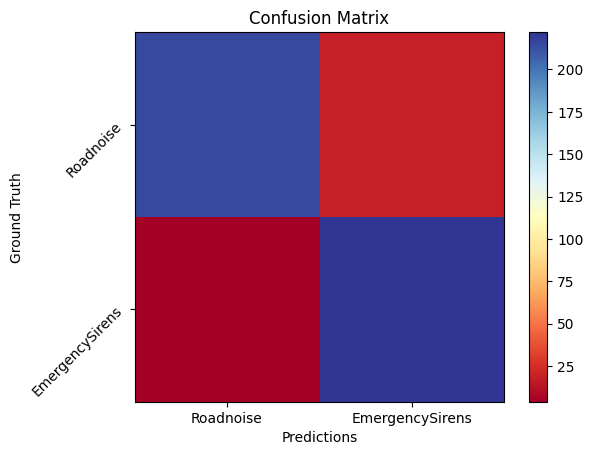

In [12]:
confusion_matrix= tf.math.confusion_matrix(labels, predictions).numpy()
fig,ax = plt.subplots()
im =ax.imshow(confusion_matrix, cmap = 'RdYlBu')


names = ["Roadnoise", "EmergencySirens"]
ax.set_xticks(np.arange(len(names)), labels=names)
ax.set_yticks(np.arange(len(names)), labels=names, rotation = 45)
plt.colorbar(im)
plt.title("Confusion Matrix")
plt.xlabel("Predictions")
plt.ylabel("Ground Truth")
plt.savefig(os.path.join(PLOT_FOLDER, f"ConfusionMatrix.png"))
plt.show()

In [21]:
#Compute precision. recall, f1score
print(confusion_matrix)
true_positives = np.diag(confusion_matrix)
false_positives = np.sum(confusion_matrix, axis = 0) - true_positives
false_negatives = np.sum(confusion_matrix, axis = 1) - true_positives

precision = true_positives/(true_positives+false_positives)
recall = true_positives/(true_positives+false_negatives)

print(f"Precision = {precision},  Recall = {recall}")

f1 = (2*np.sum(precision)*np.sum(recall))/(np.sum(precision) + np.sum(recall))
print(f"F1 score = {f1}")


[[215  19]
 [  4 222]]
Precision = [0.98173516 0.92116183],  Recall = [0.91880342 0.98230088]
F1 score = 1.9020002222398058


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=957cfe07-d816-4770-9cc0-d7c1b4767886' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>